In [ ]:
import os
import sys
import importlib

import pandas as pd
import uproot as up
import numpy as np

import matplotlib.pyplot as plt

import os.path

from matplotlib import pyplot as plt
from math import cos, cosh, radians
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator

from scipy.optimize import curve_fit

# DataFrame Construction

In [4]:
parsed_events = []
print("reading dataset")
#for file in os.listdir(r"./PrivateSignal16_test/MH1000_Ma100_MChi45"):
for file in os.listdir(r"d:\taisd\Documentos\UERJ\IC\Higgs-to-tautau\dataset\dataset"):
    print(file)
    try:
        #dataset = up.open(os.path.join(r"./PrivateSignal16_test/MH1000_Ma100_MChi45", file))
        dataset = up.open(os.path.join(r"d:\taisd\Documentos\UERJ\IC\Higgs-to-tautau\dataset\dataset", file))
        tree = dataset.get("Events;1")
        #abaixo com menos branches 
        objects = ["genWeight","nTau", "Tau_pt", "Tau_dxy", "Tau_dz", "Tau_eta", "Tau_phi", "Tau_mass","Tau_charge", "Tau_decayMode","Tau_idDecayMode", "Tau_idDecayModeNewDMs", "Tau_idDeepTau2017v2p1VSe", "Tau_idDeepTau2017v2p1VSjet", "Tau_idDeepTau2017v2p1VSmu","nJet", "Jet_area", "Jet_pt", "Jet_eta", "Jet_puId", "Jet_jetId"]
        #abaixo com mais branches
        #objects = ["genWeight","nTau", "Tau_pt", "Tau_dxy", "Tau_dz", "Tau_eta", "Tau_phi","Tau_leadTkDeltaEta", "Tau_leadTkDeltaPhi", "Tau_leadTkPtOverTauPt", "Tau_mass", "Tau_neutralIso",  "Tau_photonsOutsideSignalCone", "Tau_chargedIso", "Tau_puCorr", "Tau_rawAntiEle", "Tau_rawAntiEle2018", "Tau_rawDeepTau2017v2p1VSe", "Tau_rawDeepTau2017v2p1VSjet", "Tau_rawDeepTau2017v2p1VSmu", "Tau_rawIso", "Tau_rawIsodR03", "Tau_rawMVAnewDM2017v2", "Tau_rawMVAoldDM", "Tau_rawMVAoldDM2017v1", "Tau_rawMVAoldDM2017v2", "Tau_rawMVAoldDMdR032017v2", "Tau_charge", "Tau_decayMode", "Tau_jetIdx", "Tau_rawAntiEleCat", "Tau_rawAntiEleCat2018", "Tau_cleanmask", "Tau_genPartIdx", "Tau_genPartFlav", "Tau_idDecayMode", "Tau_idAntiEleDeadECal", "Tau_idAntiEle", "Tau_idAntiEle2018", "Tau_idAntiMu", "Tau_idDecayModeNewDMs", "Tau_idDeepTau2017v2p1VSe", "Tau_idDeepTau2017v2p1VSjet", "Tau_idDeepTau2017v2p1VSmu", "Tau_idMVAnewDM2017v2", "Tau_idMVAoldDM", "Tau_idMVAoldDM2017v1", "Tau_idMVAoldDM2017v2", "Tau_idMVAoldDMdR032017v2", "nJet", "Jet_area", "Jet_btagCSVV2", "Jet_btagDeepB", "Jet_btagDeepCvB", "Jet_btagDeepCvL", "Jet_btagDeepFlavB", "Jet_btagDeepFlavCvB", "Jet_btagDeepFlavCvL", "Jet_btagDeepFlavQG", "Jet_pt", "Jet_eta", "Jet_puId", "Jet_jetId"]
        events = tree.arrays(objects)

        for event in events:
            event = {k: getattr(event, k) for k in objects}
            parsed_events.append(event)

    except:
        print("fail")
        break
print("done")

datasets = parsed_events

reading dataset
1F343B3A-A003-9D42-956A-63D0E972E3E9.root
2FCFCFB1-696A-E84E-98B3-5FE5D2445345.root
42DAD507-A3E8-DC4D-96F4-D85B9607935C.root
55DF9C9F-05E5-8842-BF5E-CE86BCFC8882.root
8729905A-86FF-814A-B31C-6713A78BB76A.root
8CD9F2FC-76B7-E844-82EF-6B509F8C1A04.root
EBB395DE-4617-B843-95CA-FEFB86253D89.root
F38DB76E-F009-A84F-A958-368C6E212E9A.root
done


In [5]:
df = pd.DataFrame(datasets)
print(len(df))

246000


In [6]:
no_cut = pd.DataFrame(datasets)
print(len(no_cut))

246000


In [7]:
df['genWeight'].sum()


11044.014

# Object Selection (taus)

In [8]:
# Function to remove items below the threshold from a list and their corresponding items at the same index
def remove_below_threshold(row, column_name, threshold):
    # Create a list of indices of items to be removed
    indices_to_remove = [index for index, item in enumerate(row[column_name]) if item < threshold]
    # Remove items from the specified column
    row[column_name] = [item for index, item in enumerate(row[column_name]) if index not in indices_to_remove]
    # Remove items from other columns at the same index
    for col_name in row.index:
        if col_name.startswith('Tau_') and col_name != column_name:
            row[col_name] = [item for index, item in enumerate(row[col_name]) if index not in indices_to_remove]
    # Update 'nTau' value based on the modified list
    row['nTau'] = len(row[column_name])

    return row

In [9]:
# Function to remove items above the threshold from a list and their corresponding items at the same index
def remove_above_threshold(row, column_name, threshold):
    # Create a list of indices of items to be removed
    indices_to_remove = [index for index, item in enumerate(row[column_name]) if abs(item) > threshold]
    # Remove items from the specified column
    row[column_name] = [item for index, item in enumerate(row[column_name]) if index not in indices_to_remove]
    # Remove items from other columns at the same index
    for col_name in row.index:
        if col_name.startswith('Tau_') and col_name != column_name:
            row[col_name] = [item for index, item in enumerate(row[col_name]) if index not in indices_to_remove]
    # Update 'nTau' value based on the modified list
    row['nTau'] = len(row[column_name])

    return row

In [10]:
# Function to remove items not equal to the threshold from a list and their corresponding items at the same index
def remove_non_threshold(row, column_name, threshold):
    # Create a list of indices of items to be removed
    indices_to_remove = [index for index, item in enumerate(row[column_name]) if item != threshold]
    # Remove items from the specified column
    row[column_name] = [item for index, item in enumerate(row[column_name]) if index not in indices_to_remove]
    # Remove items from other columns at the same index
    for col_name in row.index:
        if col_name.startswith('Tau_') and col_name != column_name:
            row[col_name] = [item for index, item in enumerate(row[col_name]) if index not in indices_to_remove]
    # Update 'nTau' value based on the modified list
    row['nTau'] = len(row[column_name])

    return row


In [11]:
# Função para remover itens False
def remove_false_items(row, column_name):
    # Criar uma lista de índices dos itens a serem removidos (itens False)
    indices_to_remove = [index for index, item in enumerate(row[column_name]) if not item]
    
    # Remover itens da coluna especificada
    row[column_name] = [item for index, item in enumerate(row[column_name]) if index not in indices_to_remove]
    
    # Remover itens das outras colunas nos mesmos índices
    for col_name in row.index:
        if col_name.startswith('Tau_') and col_name != column_name:
            row[col_name] = [item for index, item in enumerate(row[col_name]) if index not in indices_to_remove]
    
    # Atualizar o valor de 'nTau' com base na lista modificada
    row['nTau'] = len(row[column_name])
    
    return row

In [12]:
# Threshold for filtering
threshold = 0 #0,1,3,7,15
# Column name for which to remove items below the threshold
column_name = 'Tau_idDeepTau2017v2p1VSmu'
# Apply the function to each row
df = df.apply(remove_below_threshold, args=(column_name, threshold), axis=1)

In [13]:
# Threshold for filtering
threshold = 15 #0, 1, 3, 7, 15, 31, 63, 127, 255
# Column name for which to remove items below the threshold
column_name = 'Tau_idDeepTau2017v2p1VSjet'
# Apply the function to each row
df = df.apply(remove_below_threshold, args=(column_name, threshold), axis=1)

In [14]:
# Threshold for filtering
threshold = 3 #0, 1, 3, 7, 15, 31, 63, 127, 255
# Column name for which to remove items below the threshold
column_name = 'Tau_idDeepTau2017v2p1VSe'
# Apply the function to each row
df = df.apply(remove_below_threshold, args=(column_name, threshold), axis=1)

In [15]:
df = df.apply(lambda row: remove_false_items(row, 'Tau_idDecayMode'), axis=1)
df = df.apply(lambda row: remove_false_items(row, 'Tau_idDecayModeNewDMs'), axis=1)

In [16]:
# Threshold for filtering
#threshold = 40.0
# Column name for which to remove items below the threshold
#column_name = 'Tau_pt'
# Apply the function to each row
#df = df.apply(remove_below_threshold, args=(column_name, threshold), axis=1)

In [17]:
# Threshold for filtering
#threshold = 2.1
# Column name for which to remove items below the threshold
#column_name = 'Tau_eta'
# Apply the function to each row
#df = df.apply(remove_above_threshold, args=(column_name, threshold), axis=1)

In [18]:
# Threshold for filtering
#threshold = 0.05
# Column name for which to remove items below the threshold
#column_name = 'Tau_dz'
# Apply the function to each row
#df = df.apply(remove_above_threshold, args=(column_name, threshold), axis=1)

# Event Selection (taus)

In [19]:
# df = df[df['nTau'] != 2] # Delete events with 2 taus
df = df[df['nTau'] == 2] # keep event with 2 taus
df

,genWeight,nTau,Tau_pt,Tau_dxy,Tau_dz,Tau_eta,Tau_phi,Tau_mass,Tau_charge,Tau_decayMode,...,Tau_idDecayModeNewDMs,Tau_idDeepTau2017v2p1VSe,Tau_idDeepTau2017v2p1VSjet,Tau_idDeepTau2017v2p1VSmu,nJet,Jet_area,Jet_pt,Jet_eta,Jet_puId,Jet_jetId
2,0.044603,2,"[117.87956, 80.37158]","[5.8442354e-05, -0.0013685226]","[-0.0034058094, 0.033456802]","[1.8581543, 2.0141602]","[-3.0463867, -2.0092773]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]",...,"[True, True]","[31, 255]","[255, 255]","[0, 0]",4,"[0.48876953, 0.4987793, 0.5288086, 0.38891602]","[137.625, 95.5625, 35.4375, 16.765625]","[1.8557129, 2.0151367, 2.7270508, 4.9101562]","[4, 4, 7, 6]","[0, 2, 6, 0]"
3,0.044603,2,"[134.73776, 61.82594]","[-0.00017821789, -0.0014352798]","[0.0023950338, -0.006166935]","[-0.6015625, -0.2849121]","[1.2062988, 2.0234375]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]",...,"[True, True]","[255, 255]","[255, 255]","[0, 0]",9,"[0.48876953, 0.5288086, 0.47875977, 0.50878906...","[143.375, 68.1875, 33.8125, 23.515625, 23.3281...","[-0.60424805, -0.26757812, 0.8170166, 3.485839...","[6, 4, 6, 0, 0, 0, 4, 6, 4]","[2, 2, 6, 6, 6, 6, 6, 6, 0]"
13,0.044603,2,"[131.85806, 62.7188]","[0.0009832382, -0.00079107285]","[0.00018493831, -0.0011999607]","[1.0332031, 0.10736084]","[1.2941895, 1.0068359]","[0.13952637, 0.13952637]","[-1, 1]","[0, 0]",...,"[True, True]","[15, 255]","[255, 255]","[0, 0]",6,"[0.50878906, 0.50878906, 0.4987793, 0.4987793,...","[170.875, 145.125, 72.0, 69.8125, 16.109375, 1...","[-1.1538086, 1.0322266, 0.09555054, 0.34832764...","[7, 6, 4, 7, 0, 4]","[6, 2, 2, 6, 6, 6]"
18,0.044603,2,"[218.47374, 37.48681]","[-0.00042390823, 0.0055160522]","[0.0014538765, 0.0076806545]","[-0.22128296, -0.9785156]","[-1.8659668, -1.2177734]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]",...,"[True, True]","[255, 255]","[255, 255]","[0, 0]",7,"[0.48876953, 0.5185547, 0.54833984, 0.48876953...","[235.125, 93.0625, 75.5, 64.5625, 40.9375, 22....","[-0.22213745, 1.0854492, 2.7192383, -1.7294922...","[6, 7, 7, 7, 4, 6, 6]","[2, 6, 6, 6, 2, 6, 6]"
20,0.044603,2,"[121.37193, 89.86103]","[0.000869751, -0.0008482933]","[0.00091552734, -0.0019897223]","[-1.121582, -1.0952148]","[0.71655273, 1.5998535]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]",...,"[True, True]","[255, 31]","[255, 255]","[0, 0]",4,"[0.5185547, 0.4987793, 0.4987793, 0.50878906]","[135.375, 105.125, 56.5625, 34.84375]","[-1.1186523, -1.0839844, 1.9301758, -1.0795898]","[4, 4, 7, 7]","[2, 2, 6, 6]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245983,0.044641,2,"[77.483986, 70.680756]","[-0.0004785061, 0.008132935]","[0.0018237233, -0.0031151772]","[0.07331848, 0.57629395]","[-1.8049316, -2.7861328]","[0.76171875, 1.0732422]","[-1, 1]","[1, 10]",...,"[True, True]","[63, 255]","[31, 255]","[15, 15]",5,"[0.4987793, 0.5185547, 0.5185547, 0.5786133, 0...","[85.4375, 77.25, 52.21875, 21.5625, 21.015625]","[0.067108154, 0.5842285, -0.82995605, -0.08039...","[7, 7, 7, 7, 6]","[6, 6, 6, 6, 6]"
245985,0.044641,2,"[85.07737, 76.76218]","[0.00032615662, -0.0010824203]","[-0.0033960342, -0.020664215]","[1.8911133, 2.1010742]","[-0.4946289, 0.69018555]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]",...,"[True, True]","[15, 15]","[63, 255]","[0, 0]",10,"[0.5385742, 0.48876953, 0.4987793, 0.4987793, ...","[102.6875, 98.5, 89.3125, 75.75, 29.875, 29.79...","[1.8879395, 3.0771484, 2.1000977, -0.67041016,...","[4, 7, 4, 7, 7, 7, 6, 7, 0, 6]","[2, 6, 2, 6, 6, 6, 6, 6, 6, 6]"
245996,0.044641,2,"[83.91646, 79.80151]","[-0.00036978722, 0.00085258484]","[-0.0011664033, 0.0021606684]","[-0.16082764, 0.6281738]","[-2.7250977, -1.9702148]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]",...,"[True, True]","[255, 255]","[255, 255]","[0, 0]",5,"[0.50878906, 0.48876953, 0.5288086, 0.54833984...","[106.6875, 92.9375, 59.34375, 34.34375, 17.265...","[0.62231445, -0.1496582, 1.1801758, 2.244629, ...","[4, 4, 7, 6, 7]","[6, 2, 6, 6, 6]"
245997,0.044641,2,"[116.44638, 56.146713]","[-0.000362

In [36]:
# Função para verificar se uma lista contém exatamente duas cargas opostas
def has_opposite_charges(tau_charge_list):
    return len(tau_charge_list) == 2 and tau_charge_list[0] == -tau_charge_list[1]

# Aplicando a função de verificação e filtrando o DataFrame novamente
df = df[df['Tau_charge'].apply(has_opposite_charges)]
df

,genWeight,nTau,Tau_pt,Tau_dxy,Tau_dz,Tau_eta,Tau_phi,Tau_mass,Tau_charge,Tau_decayMode,...,Tau_idDecayModeNewDMs,Tau_idDeepTau2017v2p1VSe,Tau_idDeepTau2017v2p1VSjet,Tau_idDeepTau2017v2p1VSmu,nJet,Jet_area,Jet_pt,Jet_eta,Jet_puId,Jet_jetId
13,0.044603,2,"[131.85806, 62.7188]","[0.0009832382, -0.00079107285]","[0.00018493831, -0.0011999607]","[1.0332031, 0.10736084]","[1.2941895, 1.0068359]","[0.13952637, 0.13952637]","[-1, 1]","[0, 0]",...,"[True, True]","[15, 255]","[255, 255]","[0, 0]",2,"[0.50878906, 0.4987793]","[170.875, 69.8125]","[-1.1538086, 0.34832764]","[7, 7]","[6, 6]"
18,0.044603,2,"[218.47374, 37.48681]","[-0.00042390823, 0.0055160522]","[0.0014538765, 0.0076806545]","[-0.22128296, -0.9785156]","[-1.8659668, -1.2177734]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]",...,"[True, True]","[255, 255]","[255, 255]","[0, 0]",2,"[0.5185547, 0.48876953]","[93.0625, 64.5625]","[1.0854492, -1.7294922]","[7, 7]","[6, 6]"
20,0.044603,2,"[121.37193, 89.86103]","[0.000869751, -0.0008482933]","[0.00091552734, -0.0019897223]","[-1.121582, -1.0952148]","[0.71655273, 1.5998535]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]",...,"[True, True]","[255, 31]","[255, 255]","[0, 0]",2,"[0.4987793, 0.50878906]","[56.5625, 34.84375]","[1.9301758, -1.0795898]","[7, 7]","[6, 6]"
27,0.044603,2,"[103.54347, 74.63798]","[0.00041270256, 7.516146e-05]","[-0.001864016, -0.0034058094]","[1.1965332, 0.42907715]","[2.6333008, -3.0078125]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]",...,"[True, True]","[255, 255]","[255, 255]","[0, 0]",1,[0.50878906],[79.3125],[1.151123],[7],[6]
31,0.044603,2,"[65.26165, 51.227444]","[-0.0007300377, -0.0035934448]","[0.0010553002, 0.026601791]","[-1.081543, -1.7314453]","[-0.37664795, 0.62561035]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]",...,"[True, True]","[255, 127]","[255, 255]","[0, 15]",1,[0.55859375],[49.25],[-0.83203125],[7],[6]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245983,0.044641,2,"[77.483986, 70.680756]","[-0.0004785061, 0.008132935]","[0.0018237233, -0.0031151772]","[0.07331848, 0.57629395]","[-1.8049316, -2.7861328]","[0.76171875, 1.0732422]","[-1, 1]","[1, 10]",...,"[True, True]","[63, 255]","[31, 255]","[15, 15]",4,"[0.4987793, 0.5185547, 0.5185547, 0.5786133]","[85.4375, 77.25, 52.21875, 21.5625]","[0.067108154, 0.5842285, -0.82995605, -0.08039...","[7, 7, 7, 7]","[6, 6, 6, 6]"
245985,0.044641,2,"[85.07737, 76.76218]","[0.00032615662, -0.0010824203]","[-0.0033960342, -0.020664215]","[1.8911133, 2.1010742]","[-0.4946289, 0.69018555]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]",...,"[True, True]","[15, 15]","[63, 255]","[0, 0]",4,"[0.4987793, 0.47875977, 0.54833984, 0.5185547]","[75.75, 29.875, 29.796875, 20.0]","[-0.67041016, 2.145996, 1.1733398, -1.2629395]","[7, 7, 7, 7]","[6, 6, 6, 6]"
245996,0.044641,2,"[83.91646, 79.80151]","[-0.00036978722, 0.00085258484]","[-0.0011664033, 0.0021606684]","[-0.16082764, 0.6281738]","[-2.7250977, -1.9702148]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]",...,"[True, True]","[255, 255]","[255, 255]","[0, 0]",1,[0.5288086],[59.34375],[1.1801758],[7],[6]
245997,0.044641,2,"[116.44638, 56.146713]","[-0.00036215782, -0.0013999939]","[0.00011245906, 0.011298656]","[-0.46069336, -1.3952637]","[1.0549316, 0.45428467]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]",...,"[True, True]","[255, 31]","[255, 255]","[0, 0]",2,"[0.47875977, 0.47875977]","[145.75, 79.5]","[1.5932617, 0.3394165]","[7, 7]","[6, 6]"


# Object Selection (jets)


In [20]:
# Function to remove items below the threshold from a list and their corresponding items at the same index
def remove_below_threshold_1(row, column_name, threshold):
    # Create a list of indices of items to be removed
    indices_to_remove = [index for index, item in enumerate(row[column_name]) if item < threshold]
    # Remove items from the specified column
    row[column_name] = [item for index, item in enumerate(row[column_name]) if index not in indices_to_remove]
    # Remove items from other columns at the same index
    for col_name in row.index:
        if col_name.startswith('Jet_') and col_name != column_name:
            row[col_name] = [item for index, item in enumerate(row[col_name]) if index not in indices_to_remove]
    # Update 'nTau' value based on the modified list
    row['nJet'] = len(row[column_name])

    return row

In [21]:
# Function to remove items above the threshold from a list and their corresponding items at the same index
def remove_above_threshold_1(row, column_name, threshold):
    # Create a list of indices of items to be removed
    indices_to_remove = [index for index, item in enumerate(row[column_name]) if abs(item) > threshold]
    # Remove items from the specified column
    row[column_name] = [item for index, item in enumerate(row[column_name]) if index not in indices_to_remove]
    # Remove items from other columns at the same index
    for col_name in row.index:
        if col_name.startswith('Jet_') and col_name != column_name:
            row[col_name] = [item for index, item in enumerate(row[col_name]) if index not in indices_to_remove]
    # Update 'nTau' value based on the modified list
    row['nJet'] = len(row[column_name])

    return row

In [22]:
# Function to remove items different threshold from a list and their corresponding items at the same index
def remove_dif_threshold_1(row, column_name, threshold):
    # Create a list of indices of items to be removed
    indices_to_remove = [index for index, item in enumerate(row[column_name]) if abs(item) != threshold]
    # Remove items from the specified column
    row[column_name] = [item for index, item in enumerate(row[column_name]) if index not in indices_to_remove]
    # Remove items from other columns at the same index
    for col_name in row.index:
        if col_name.startswith('Jet_') and col_name != column_name:
            row[col_name] = [item for index, item in enumerate(row[col_name]) if index not in indices_to_remove]
    # Update 'nTau' value based on the modified list
    row['nJet'] = len(row[column_name])

    return row

In [23]:
# Threshold for filtering
threshold = 20.0
# Column name for which to remove items below the threshold
column_name = 'Jet_pt'
# Apply the function to each row
df = df.apply(remove_below_threshold_1, args=(column_name, threshold), axis=1)

In [24]:
# Threshold for filtering
threshold = 2.4
# Column name for which to remove items below the threshold
column_name = 'Jet_eta'
# Apply the function to each row
df = df.apply(remove_above_threshold_1, args=(column_name, threshold), axis=1)

In [25]:
# Threshold for filtering
threshold = 0.4
# Column name for which to remove items below the threshold
column_name = 'Jet_area'
# Apply the function to each row
df = df.apply(remove_below_threshold_1, args=(column_name, threshold), axis=1)

In [26]:
# Threshold for filtering
threshold = 7
# Column name for which to remove items below the threshold
column_name = 'Jet_puId'
# Apply the function to each row
df = df.apply(remove_dif_threshold_1, args=(column_name, threshold), axis=1)

# Event Selection (jets)

In [27]:
# df = df[df['nJet'] <= 1] # Delete events with 1 or more jets
df = df[df['nJet'] >= 1] # keep event with 1 or more jets
df

,genWeight,nTau,Tau_pt,Tau_dxy,Tau_dz,Tau_eta,Tau_phi,Tau_mass,Tau_charge,Tau_decayMode,...,Tau_idDecayModeNewDMs,Tau_idDeepTau2017v2p1VSe,Tau_idDeepTau2017v2p1VSjet,Tau_idDeepTau2017v2p1VSmu,nJet,Jet_area,Jet_pt,Jet_eta,Jet_puId,Jet_jetId
13,0.044603,2,"[131.85806, 62.7188]","[0.0009832382, -0.00079107285]","[0.00018493831, -0.0011999607]","[1.0332031, 0.10736084]","[1.2941895, 1.0068359]","[0.13952637, 0.13952637]","[-1, 1]","[0, 0]",...,"[True, True]","[15, 255]","[255, 255]","[0, 0]",2,"[0.50878906, 0.4987793]","[170.875, 69.8125]","[-1.1538086, 0.34832764]","[7, 7]","[6, 6]"
18,0.044603,2,"[218.47374, 37.48681]","[-0.00042390823, 0.0055160522]","[0.0014538765, 0.0076806545]","[-0.22128296, -0.9785156]","[-1.8659668, -1.2177734]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]",...,"[True, True]","[255, 255]","[255, 255]","[0, 0]",2,"[0.5185547, 0.48876953]","[93.0625, 64.5625]","[1.0854492, -1.7294922]","[7, 7]","[6, 6]"
20,0.044603,2,"[121.37193, 89.86103]","[0.000869751, -0.0008482933]","[0.00091552734, -0.0019897223]","[-1.121582, -1.0952148]","[0.71655273, 1.5998535]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]",...,"[True, True]","[255, 31]","[255, 255]","[0, 0]",2,"[0.4987793, 0.50878906]","[56.5625, 34.84375]","[1.9301758, -1.0795898]","[7, 7]","[6, 6]"
27,0.044603,2,"[103.54347, 74.63798]","[0.00041270256, 7.516146e-05]","[-0.001864016, -0.0034058094]","[1.1965332, 0.42907715]","[2.6333008, -3.0078125]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]",...,"[True, True]","[255, 255]","[255, 255]","[0, 0]",1,[0.50878906],[79.3125],[1.151123],[7],[6]
31,0.044603,2,"[65.26165, 51.227444]","[-0.0007300377, -0.0035934448]","[0.0010553002, 0.026601791]","[-1.081543, -1.7314453]","[-0.37664795, 0.62561035]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]",...,"[True, True]","[255, 127]","[255, 255]","[0, 15]",1,[0.55859375],[49.25],[-0.83203125],[7],[6]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245983,0.044641,2,"[77.483986, 70.680756]","[-0.0004785061, 0.008132935]","[0.0018237233, -0.0031151772]","[0.07331848, 0.57629395]","[-1.8049316, -2.7861328]","[0.76171875, 1.0732422]","[-1, 1]","[1, 10]",...,"[True, True]","[63, 255]","[31, 255]","[15, 15]",4,"[0.4987793, 0.5185547, 0.5185547, 0.5786133]","[85.4375, 77.25, 52.21875, 21.5625]","[0.067108154, 0.5842285, -0.82995605, -0.08039...","[7, 7, 7, 7]","[6, 6, 6, 6]"
245985,0.044641,2,"[85.07737, 76.76218]","[0.00032615662, -0.0010824203]","[-0.0033960342, -0.020664215]","[1.8911133, 2.1010742]","[-0.4946289, 0.69018555]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]",...,"[True, True]","[15, 15]","[63, 255]","[0, 0]",4,"[0.4987793, 0.47875977, 0.54833984, 0.5185547]","[75.75, 29.875, 29.796875, 20.0]","[-0.67041016, 2.145996, 1.1733398, -1.2629395]","[7, 7, 7, 7]","[6, 6, 6, 6]"
245996,0.044641,2,"[83.91646, 79.80151]","[-0.00036978722, 0.00085258484]","[-0.0011664033, 0.0021606684]","[-0.16082764, 0.6281738]","[-2.7250977, -1.9702148]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]",...,"[True, True]","[255, 255]","[255, 255]","[0, 0]",1,[0.5288086],[59.34375],[1.1801758],[7],[6]
245997,0.044641,2,"[116.44638, 56.146713]","[-0.00036215782, -0.0013999939]","[0.00011245906, 0.011298656]","[-0.46069336, -1.3952637]","[1.0549316, 0.45428467]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]",...,"[True, True]","[255, 31]","[255, 255]","[0, 0]",2,"[0.47875977, 0.47875977]","[145.75, 79.5]","[1.5932617, 0.3394165]","[7, 7]","[6, 6]"


# Massa Invariante 

83.57873303771365


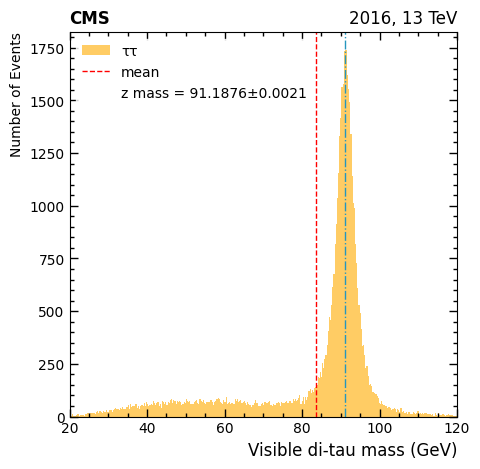

In [37]:
pts = []
etas = []
phis = []
massa = []

for i in range(len(df)):
    pts.append(df["Tau_pt"].iloc[i])
    etas.append(df["Tau_eta"].iloc[i])
    phis.append(df["Tau_phi"].iloc[i])
for i in range(len(pts)):
    try:
        massa.append((2 * pts[i][0] * pts[i][1] * (cosh(etas[i][0] - etas[i][1]) - cos(phis[i][0] - phis[i][1]))) ** (1/2))
    except:
        pass

z_mass = 91.1876#±0.0021

mean = np.mean(massa)
print(mean)
rms = np.sqrt(mean)

plt.figure(figsize=(5, 5))
n, bins, patches = plt.hist(massa, bins=1500, color="#ffcc64") #bins é 1500
plt.xlim(20, 120)
plt.xlabel("Visible di-tau mass (GeV)", loc="right", fontsize='large')
plt.ylabel("Number of Events", loc="top")
yellow_patch = mpatches.Patch(color='#ffcc64', label='ττ')
plt.legend(handles=[yellow_patch], edgecolor='white', title_fontsize='xx-small')
nova_legenda = plt.legend([patches[0], plt.axvline(mean, color='r', linestyle='dashed', linewidth=1),
                           plt.axvline(rms, color='white', linestyle='dashdot', linewidth=1),
                           plt.axvline(z_mass, color='#2596be', linestyle='dashdot', linewidth=1)],
                            ['ττ','mean', 'z mass = 91.1876±0.0021'], edgecolor='white', title_fontsize= 'xx-small')
plt.title("CMS", loc="left", fontweight='bold')
plt.title("2016, 13 TeV", loc="right")

plt.tick_params(axis='both', bottom=True, top=True, left=True, right=True,
                direction='in', length=6, width=1, colors='black')
plt.tick_params(axis='both', which='minor', direction='in', length=3, width=1, colors='black', top=True, right=True)
ax = plt.gca()
ax.set_adjustable('datalim')
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(50))

plt.show()


In [38]:
print(len(df))

50173


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


90.88968715207989


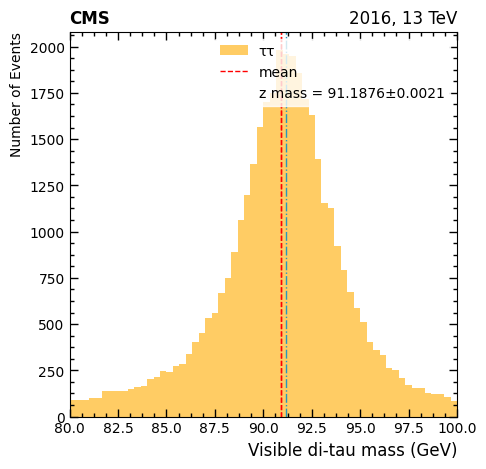

In [39]:
pts = []
etas = []
phis = []
massa2 = []

for i in range(len(df)):
    pts.append(df["Tau_pt"].iloc[i])
    etas.append(df["Tau_eta"].iloc[i])
    phis.append(df["Tau_phi"].iloc[i])
for i in range(len(pts)):
    try:
        massa2.append((2 * pts[i][0] * pts[i][1] * (cosh(etas[i][0] - etas[i][1]) - cos(phis[i][0] - phis[i][1]))) ** (1/2))
    except:
        pass

massa_corte = []
z_mass = 91.1876#±0.0021

for i in massa2:
  if i > 80.:
    if i < 100.:
      massa_corte.append(i)

mean = np.mean(massa_corte)
print(mean)
rms = np.sqrt(mean)


plt.figure(figsize=(5,5))
n, bins, patches = plt.hist(massa_corte, bins = 60, color = "#ffcc64")
plt.axvline(mean, color='r', linestyle='dashed', linewidth=1)
plt.axvline(rms, color='white', linestyle='dashdot', linewidth=1)
#patches[48].set_fc('#2596be')
plt.xlim(80,100)
#plt.ylim(0,1900)
plt.xlabel("Visible di-tau mass (GeV)", loc="right", fontsize='large')
plt.ylabel("Number of Events", loc="top")
#blue_patch = mpatches.Patch(color='#2596be', label='Z→ττ')
yellow_patch = mpatches.Patch(color='#ffcc64', label='ττ')
plt.legend(handles=[yellow_patch], edgecolor='white', title_fontsize= 'xx-small')
legenda_existente = plt.legend()
nova_legenda = plt.legend([patches[0], plt.axvline(mean, color='r', linestyle='dashed', linewidth=1),
                           plt.axvline(rms, color='white', linestyle='dashdot', linewidth=1),
                           plt.axvline(z_mass, color='#2596be', linestyle='dashdot', linewidth=1)],
                            ['ττ','mean', 'z mass = 91.1876±0.0021'], edgecolor='white', title_fontsize= 'xx-small')
plt.title("CMS", loc="left", fontweight='bold')
plt.title("2016, 13 TeV", loc="right")

plt.tick_params(axis='both', bottom=True, top=True, left=True, right=True,
                direction='in', length=6, width=1, colors='black')
plt.tick_params(axis='both', which='minor', direction='in', length=3, width=1, colors='black', top=True, right=True)
ax = plt.gca()
ax.set_adjustable('datalim')
ax.xaxis.set_minor_locator(MultipleLocator(0.625))
ax.yaxis.set_minor_locator(MultipleLocator(62.50))

plt.show()

C:\Users\taisd\AppData\Local\Temp\ipykernel_16960\3720660443.py:31: UserWarning: The label '_nolegend_' of <matplotlib.patches.Rectangle object at 0x0000027581D4CE20> starts with '_'. It is thus excluded from the legend.
  plt.legend(handles=[yellow_patch, patches[0], plt.axvline(mean, color='r', linestyle='dashed', linewidth=1),
C:\Users\taisd\AppData\Local\Temp\ipykernel_16960\3720660443.py:31: UserWarning: The label '_child61' of <matplotlib.lines.Line2D object at 0x000002757A8A34C0> starts with '_'. It is thus excluded from the legend.
  plt.legend(handles=[yellow_patch, patches[0], plt.axvline(mean, color='r', linestyle='dashed', linewidth=1),


<Figure size 640x480 with 0 Axes>

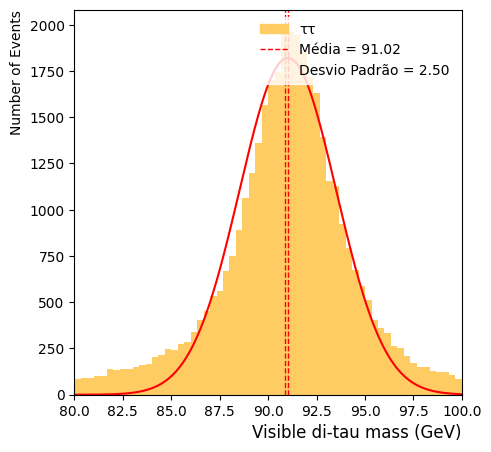

In [40]:
# Função de ajuste gaussiano
def gaussiana(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Valores iniciais estimados para os parâmetros do ajuste
parametros_iniciais = [1000, np.mean(massa_corte), np.std(massa_corte)]

# Realize o ajuste usando curve_fit
parametros_otimizados, matriz_covariancia = curve_fit(gaussiana, bins[:-1], n, p0=parametros_iniciais)

# Extraia os parâmetros ajustados
A, mu, sigma = parametros_otimizados

# Crie um conjunto de pontos para plotar a curva ajustada
x_fit = np.linspace(min(bins), max(bins), 1000)
y_fit = gaussiana(x_fit, A, mu, sigma)

# Limpeza do gráfico para evitar que dois gráficos se sobreponham
plt.clf()

# histograma
plt.figure(figsize=(5, 5))
plt.hist(massa_corte, bins=60, color="#ffcc64")
plt.xlim(80, 100)
plt.xlabel("Visible di-tau mass (GeV)", loc="right", fontsize='large')
plt.ylabel("Number of Events", loc="top")

# Fit
plt.plot(x_fit, y_fit, 'r-', label=f'Ajuste Gaussiano\nMédia = {mu:.2f}, Desvio Padrão = {sigma:.2f}')
yellow_patch = mpatches.Patch(color='#ffcc64', label='ττ')
plt.legend(handles=[yellow_patch, patches[0], plt.axvline(mean, color='r', linestyle='dashed', linewidth=1),
                    plt.axvline(mu, color='r', linestyle='dashed', linewidth=1, label=f'Média = {mu:.2f}'),
                    plt.axvline(sigma, color='white', linestyle='dashdot', linewidth=1, label=f'Desvio Padrão = {sigma:.2f}')],
           edgecolor='white', title_fontsize='xx-small', loc='upper right')

plt.show()
desv_pad = sigma

# Branch Ratio 

In [41]:
BR = (len(massa_corte))/(len(no_cut))*100
print("A razão de decaimento encontrada foi de", round(BR,3), "%")

A razão de decaimento encontrada foi de 15.171 %


# Salvando os dados (opcional)


In [33]:
##output_file = 'analysis_something.root'

# Converta o DataFrame em um dicionário de arrays numpy
##data_dict = {col: df[col].values for col in df.columns}

# Create a dictionary of column data types
##dtype_dict = {col: df[col].dtype for col in df.columns}

# Convert the DataFrame to a dictionary with NumPy arrays
##data_dict = {col: df[col].values for col in df.columns}

In [34]:
# Pegue os nomes das colunas em uma lista
##col_names = df.columns.tolist()

# Pegue os valores das colunas em uma lista de listas
##col_values = df.values.tolist()

#awkward_arrays = [ak.Array(values) for values in col_values] 

In [35]:
##output_filename = "analysis_official_wrong_cut.root"
##tree_name = "Events"

# Crie um dicionário de ramos onde a chave é o nome do ramo e o valor é o array correspondente
##branches = {}

# Itere pelas colunas do DataFrame
##for column_name in df.columns:
    # Se a coluna for a primeira ou a quadragesima nona branch, considere os inteiros
    ##if column_name == 'nTau' or column_name == 'nJet':
        ##numpy_array = np.array(df[column_name])
    ##else:
        # Crie um DataFrame intermediário para a coluna de objeto Awkward Array
        ##intermediate_df = pd.DataFrame(df[column_name])
        
        # Converta o DataFrame intermediário em NumPy array
        ##numpy_array = np.array(intermediate_df.iloc[:, 0])  # Use apenas a primeira coluna
        
    # Adicione o NumPy array ao dicionário de ramos
    ##branches[column_name] = numpy_array

# Crie o arquivo ROOT e insira os ramos
##with up.recreate(output_filename) as output_file:
    ##output_file[tree_name] = branches